<a href="https://colab.research.google.com/github/LEEINSEO-0118/Seed-size-calculator/blob/main/%08CalculateSize_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import argparse
import random as rng


In [ ]:
# 기준이 되는 객체의 사이즈 측정
SCALE = 30
# PAPER_W = 210 * SCALE
# PAPER_H = 297 * SCALE
PAPER_W = 30 * SCALE
PAPER_H = 30 * SCALE

In [ ]:
def load_image(path, scale = 0.7):
    img = cv2.imread(path)
    img_resized = cv2.resize(img, (0,0), None, scale, scale)
    return img_resized

def show_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.xticks([])
    plt.yticks([]) # 얘네 넣으면 축에 index가 사라지네?
    plt.imshow(img)
    plt.show()

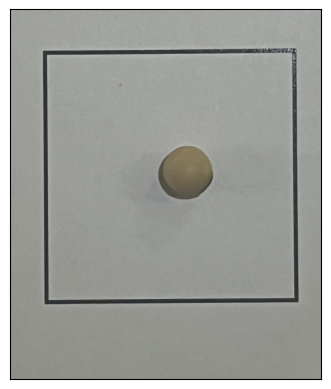

(1272, 1072, 3)


In [ ]:
# img_original = load_image(path='/content/drive/MyDrive/졸업논문/1.jpeg')
img_original = load_image(path='/content/drive/MyDrive/졸업논문/soybean_test_1.jpeg')
show_image(img_original)
print(img_original.shape)

In [ ]:
def preprocess_image(img, thresh_1=57, thresh_2=232):
    img_gray  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)      # 그레이 스케일 변환
    img_blur  = cv2.GaussianBlur(img_gray, (5,5), 1)       # 필터처리
    img_canny = cv2.Canny(img_blur, thresh_1, thresh_2)    # edge detector

    kernel = np.ones((3,3))    #4
    img_dilated = cv2.dilate(img_canny, kernel, iterations=1)    # edge 라인을 굵게
    img_closed = cv2.morphologyEx(img_dilated, cv2.MORPH_CLOSE,
                                  kernel, iterations=4)          # edge 내부 small holes 제거, edge를 명확하게

    img_preprocessed = img_closed.copy()

    img_each_step = {'img_dilated': img_dilated,
                     'img_canny'  : img_canny,
                     'img_blur'   : img_blur,
                     'img_gray'   : img_gray}

    return img_preprocessed, img_each_step

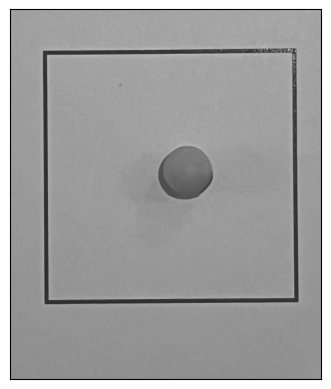

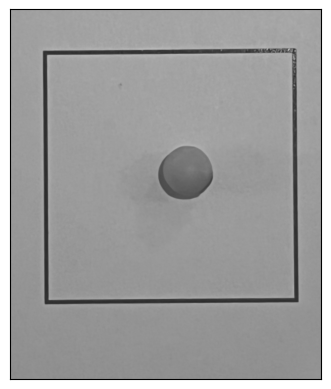

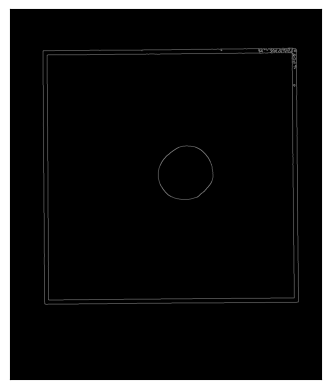

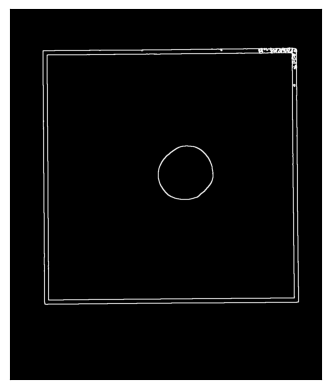

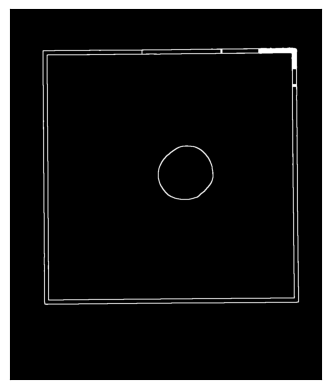

In [ ]:
img_preprocessed, img_each_step = preprocess_image(img_original)
show_image(img_each_step['img_gray'])
show_image(img_each_step['img_blur'])
show_image(img_each_step['img_canny'])
show_image(img_each_step['img_dilated'])
show_image(img_preprocessed)

In [ ]:
def find_contours(img_preprocessed, img_original, epsilon_param=0.04):
    contours, hierarchy = cv2.findContours(image=img_preprocessed,
                                           mode=cv2.RETR_EXTERNAL, # for outermost contours
                                           method=cv2.CHAIN_APPROX_NONE)  # find contour

    img_contour = img_original.copy() # copy origin image
    cv2.drawContours(img_contour, contours, -1, (203,192,255), 6)  # draw contour on copied origin image

    polygons = []

    for contour in contours:
        epsilon = epsilon_param * cv2.arcLength(curve=contour,
                                                closed=True)  # epsilon 값이 작으면 많은 코너를 탐지한다.
                                                              # 사이즈 기준 객체의 정확한 코너를 찾기 위해서 epsilon 값을 설정하는 것에 주의해야 함
        polygon = cv2.approxPolyDP(curve=contour,
                                   epsilon=epsilon, closed=True)  # contour를 통해 코너(Curves) 추정
        polygon = polygon.reshape(4, 2)  # original output of cv2.approxPolyDP() is in the format (number of corners, 1, 2), where the middle axis is irrelevant in our case. Hence, we can safely discard it.
        polygons.append(polygon)
        for point in polygon:
            img_contour = cv2.circle(img=img_contour, center=point,
                                     radius=8, color=(0,240,0),
                                     thickness=-1)

    return polygons, img_contour

[[[ 982  135]]

 [[ 112  143]]

 [[ 119 1015]]

 [[ 991 1008]]]


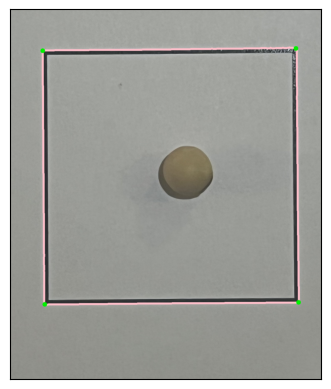

array([[ 982,  135],
       [ 112,  143],
       [ 119, 1015],
       [ 991, 1008]], dtype=int32)

In [ ]:
# 모서리와 꼭지점 받기
polygons, img_contours = find_contours(img_preprocessed,
                                       img_original,
                                       epsilon_param=0.04)
# Show
show_image(img_contours)
polygons[0]

In [ ]:
# Perspective Transform
def reorder_coords(polygon):
    rect_coords = np.zeros((4, 2)) # 각 모서리 구해서 넣기

    # 왼쪽 상단이 0, 0
    # 좌표 합 가장 작은 것 -> 좌측 상단
    # 좌표 합 가장 큰 것 -> 우측 하단
    add = polygon.sum(axis=1) # 컬럼을 기준으로 합치기
    rect_coords[0] = polygon[np.argmin(add)]    # Top left # 최소값의 index 반환
    rect_coords[3] = polygon[np.argmax(add)]    # Bottom right

    # 차 y - x
    # 좌표 차 가장 작은 것 -> 우측 상한
    # 좌표 차 가장 큰 것 -> 좌측 하단
    subtract = np.diff(polygon, axis=1)
    rect_coords[1] = polygon[np.argmin(subtract)]    # Top right
    rect_coords[2] = polygon[np.argmax(subtract)]    # Bottom left

    return rect_coords

In [ ]:
# 모서리 좌표
rect_coords = reorder_coords(polygons[0])
rect_coords

array([[ 112.,  143.],
       [ 982.,  135.],
       [ 119., 1015.],
       [ 991., 1008.]])

In [ ]:
# 이미지를 옮길 바탕 좌표 생성
paper_coords = np.float32([[0,0],                # Top left
                           [PAPER_W,0],          # Top right
                           [0,PAPER_H],          # Bottom left
                           [PAPER_W,PAPER_H]])   # Bottom right
paper_coords

array([[  0.,   0.],
       [900.,   0.],
       [  0., 900.],
       [900., 900.]], dtype=float32)

In [ ]:
def warp_image(rect_coords, paper_coords, img_original, pad=25):

    # 실제 이미지에서 template으로 변환하는 homography 생성
    matrix, _ = cv2.findHomography(rect_coords, paper_coords)

    # trasform
    img_warped = cv2.warpPerspective(img_original, matrix,
                                        (PAPER_W, PAPER_H))

    # 이미지가 원하지 않는 영역을 가지기에 pad 만큼 그것을 제거
    # 음.. 꼭 해야하나..?
    # -> 이거 안하니까 계산기 corner가 안 찾아짐... 미친.. 왜?
    warped_h = img_warped.shape[0]
    warped_w = img_warped.shape[1]
    img_warped = img_warped[pad:warped_h-pad, pad:warped_w-pad]

    return img_warped

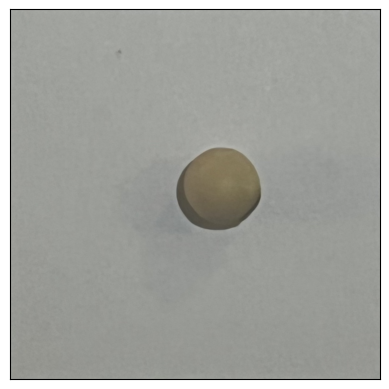

(850, 850, 3)


In [ ]:
img_warped = warp_image(rect_coords, paper_coords, img_original)
show_image(img_warped)
print(img_warped.shape)

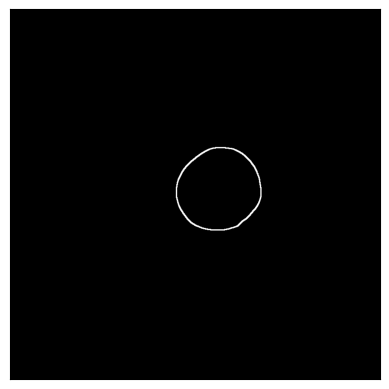

In [ ]:
img_warped_preprocessed, _ = preprocess_image(img_warped)
show_image(img_warped_preprocessed)

In [ ]:
def find_ellipse_contours(img_preprocessed, img_original):

    thresh_1, thresh_2 = 57, 232
    canny_output = cv2.Canny(img_preprocessed, thresh_1, thresh_2)
    contours, hierarchy = cv2.findContours(image=img_preprocessed,
                                           mode=cv2.RETR_EXTERNAL, # for outermost contours
                                           method=cv2.CHAIN_APPROX_NONE)  # find contour

    # Find the rotated rectangles and ellipses for each contour
    minRect = [None]*len(contours)
    for i, c in enumerate(contours):
        minRect[i] = cv2.minAreaRect(c)


    img_contour = img_original.copy()

    polygons = cv2.boxPoints(minRect[i])
    polygons = np.intp(polygons) #np.intp: Integer used for indexing (same as C ssize_t; normally either int32 or int64)
    cv2.drawContours(img_contour, [polygons], -1, (255,0,0), 3)

    for point in polygons:
        img_contour = cv2.circle(img=img_contour, center=point, radius=8, color=(0,240,0), thickness=-1)

    return img_contour, polygons

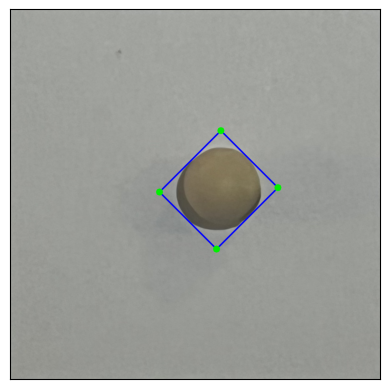

array([[343, 420],
       [484, 279],
       [615, 410],
       [474, 551]])

In [ ]:
img_contours_warped, polygons = find_ellipse_contours(img_warped_preprocessed, img_warped)
show_image(img_contours_warped)
polygons

In [ ]:
polygons

array([[343, 420],
       [484, 279],
       [615, 410],
       [474, 551]])

In [ ]:
def calculate_sizes(polygons):
    sizes = []
    lens = len(polygons)
    for i in range(lens):
        for j in range(i+1, lens):
            dist = cv2.norm(polygons[i], polygons[j], cv2.NORM_L2)
            sizes.append([dist, [i, j]]) # 길이와 두 점의 index 저장

    sorted_sizes = sorted(sizes, key=lambda x: x[0])

    result = [sorted_sizes[0], sorted_sizes[3]]
    return result
seed_size = calculate_sizes(polygons)
seed_size

[[185.26197667087544, [0, 3]], [199.4041122946064, [2, 3]]]

In [ ]:
def convert_to_mm(sizes_pixel, img_warped):
    warped_h = img_warped.shape[0]
    warped_w = img_warped.shape[1]

    scale_h = PAPER_H / warped_h    # 높이 비율
    scale_w = PAPER_W / warped_w    # 너비 비율


    size_pixel_h, size_pixel_w = sizes_pixel[0][0], sizes_pixel[1][0]
    size_mm_h = size_pixel_h * scale_h / SCALE
    size_mm_w = size_pixel_w * scale_w / SCALE

    sizes_mm = [[size_mm_h, sizes_pixel[0][1]], [size_mm_w, sizes_pixel[1][1]]]

    return sizes_mm

sizes_mm = convert_to_mm(seed_size, img_warped)
sizes_mm

[[6.538658000148545, [0, 3]], [7.037792198633167, [2, 3]]]

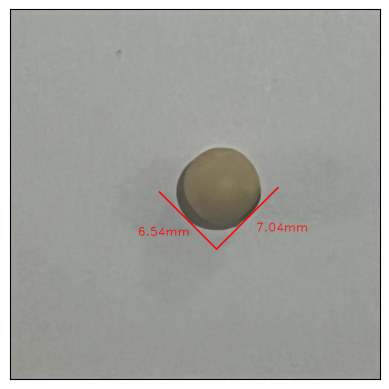

In [ ]:
def write_size(polygons, sizes, img_warped):

    img_result = img_warped.copy()

    for size, idx in (sizes):

        cv2.line(img_result, polygons[idx[0]], polygons[idx[1]], (0,0,255), 4)
        cv2.putText(img_result, f'{np.float32(size):.2f}mm',
                    (polygons[idx[0]][0]-50, polygons[idx[0]][1]+100),
                    cv2.FONT_HERSHEY_DUPLEX, 0.9, (0,0,255), 1)

    return img_result

img_result = write_size(polygons, sizes_mm, img_warped)
show_image(img_result)

In [ ]:
def measure_size(path, img_original_scale=0.7,
                 PAPER_W=30, PAPER_H=30, SCALE=30,
                 paper_eps_param=0.04,canny_thresh_1=57, canny_thresh_2=232):

    PAPER_W = PAPER_W * SCALE
    PAPER_H = PAPER_H * SCALE

    # Loading and preprocessing original image.
    img_original = load_image(path=path, scale=img_original_scale)
    img_preprocessed, img_each_step = preprocess_image(img_original,
                                                       thresh_1=canny_thresh_1,
                                                       thresh_2=canny_thresh_2)

    # Finding paper contours and corners.
    polygons, img_contours = find_contours(img_preprocessed,
                                           img_original,
                                           epsilon_param=paper_eps_param)

    # Reordering paper corners.
    rect_coords = np.float32(reorder_coords(polygons[0]))

    # Warping image according to paper contours.
    paper_coords = np.float32([[0,0],
                               [PAPER_W,0],
                               [0,PAPER_H],
                               [PAPER_W,PAPER_H]])
    img_warped = warp_image(rect_coords, paper_coords, img_original)

    # Preprocessing the warped image.
    img_warped_preprocessed, _ = preprocess_image(img_warped)

    # Finding seed rectangle
    img_contours_warped, polygons = find_ellipse_contours(img_warped_preprocessed, img_warped)


    # Edge langth calculation.
    seed_size = calculate_sizes(polygons)
    sizes_mm = convert_to_mm(seed_size, img_warped)
    img_result = write_size(polygons, sizes_mm, img_warped)

    return img_result

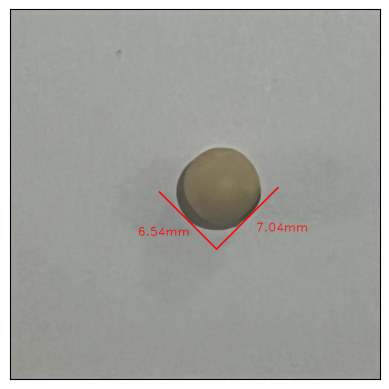

In [ ]:
show_image(measure_size('/content/drive/MyDrive/졸업논문/soybean_test_1.jpeg'))